# Running LAMMPS with pyiron

This notebook illustrates how to run a LAMMPS job with pyiron, including annotation of the data using the ontology. For more details about pyiron, see [here](https://pyiron.org/). At the moment, only Minimisation calculations are supported.

We start by importing the necessary classes

In [1]:
from pyiron_atomistics import Project
from pyscal_rdf import StructureGraph
from rdfjobs import RDFLammps

In [35]:
import pandas as pd
import numpy as np

Start by creating a pyiron project

In [2]:
pr = Project("lammps_rdf")

We also need to create a `StructureGraph` object

In [3]:
s = StructureGraph(store=pr)

Notice that we provided the project as an input to the store parameter. This tells the `StructureGraph` that we will store all the data within the project.

We can start by creating a structure

In [4]:
struct = s.create_element('Fe', repetitions=(2,2,2))

Fe


Also check out the `s.create_structure` method, which helps in creation of any lattice.

Now we can create a pyiron Job

In [5]:
job = pr.create_job(job_type=RDFLammps, 
                        job_name='lammps_rdf_j1', 
                        delete_existing_job=True)

We assign the structure

In [6]:
job.structure = struct

Now add a potential

In [11]:
job.list_potentials()[50:60]

['2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr2',
 '2018--Jeong-G-U--Pd-Fe--LAMMPS--ipr1',
 '2018--Zhou-X-W--Fe-Ni-Cr--LAMMPS--ipr1',
 '2018--Zhou-X-W--Fe-Ni-Cr--LAMMPS--ipr2',
 '2019--Aslam-I--Fe-Mn-Si-C--LAMMPS--ipr1',
 '2019--Byggmastar-J--Fe-O--LAMMPS--ipr1',
 '2019--Mendelev-M-I--Fe-Ni-Cr--LAMMPS--ipr1',
 '2020--Byggmastar-J--Fe--LAMMPS--ipr1',
 '2020--Farkas-D--Fe-Ni-Cr-Co-Al--LAMMPS--ipr1',
 '2020--Groger-R--Co-Cr-Fe-Mn-Ni--LAMMPS--ipr1']

We will use the `2019--Mendelev-M-I--Fe-Ni-Cr--LAMMPS--ipr1` potential as an example.

In [12]:
job.potential = '2019--Mendelev-M-I--Fe-Ni-Cr--LAMMPS--ipr1'

Now we can run the minimisation job.

In [13]:
job.calc_minimize()
job.run()

The job lammps_rdf_j1 was saved and received the ID: 720


After the Job is done, the data is automatically added to the graph. We can check the structuregraph object now.

In [14]:
s.n_samples

2

We have two samples, the initial one we created, and the relaxed structure. We can also visualise the graph.

In [15]:
s.samples

[rdflib.term.BNode('Sample_1'), rdflib.term.BNode('Sample_2')]

In [16]:
ini_sample = s.get_sample(s.samples[0])

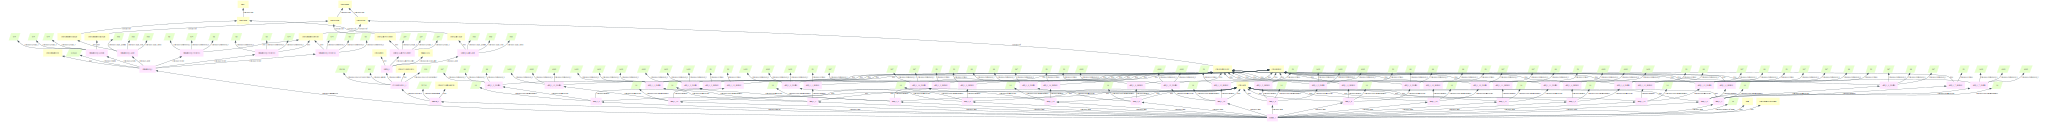

In [17]:
ini_sample.visualise(backend='graphviz')

We can also query the database. For example we can query for all structures with 16 atoms, and see what their spacegroup symbol is:

In [20]:
query = """
PREFIX cmso: <https://purls.helmholtz-metadaten.de/cmso/>
SELECT DISTINCT ?symbol
WHERE {
    ?sample cmso:hasNumberOfAtoms ?number .
    ?sample cmso:hasMaterial ?material .
    ?material cmso:hasStructure ?structure .
    ?structure cmso:hasSpaceGroupSymbol ?symbol .
FILTER (?number="16"^^xsd:integer)
}"""

In [22]:
res = s.graph.query(query)

In [23]:
for r in res:
    print(r[0])

Im-3m


We can also do more, workflow related queries. The query below asks for samples which were derived from another sample. 

In [24]:
query="""
PREFIX cmso: <https://purls.helmholtz-metadaten.de/cmso/>
PREFIX provo: <http://www.w3.org/ns/prov#>
SELECT DISTINCT ?sample1 ?sample2
WHERE {
    ?sample2 provo:wasDerivedFrom ?sample1
}"""

In [25]:
res = s.graph.query(query)

In [36]:
pd.DataFrame(res, columns=["sample", "derived sample"])

,sample,derived sample
0,Sample_1,Sample_2


Sample_2 is the minimised one, and Sample_1 is the original structure.

We can also ask for all structures generated by pyiron using LAMMPS

In [45]:
query="""
PREFIX cmso: <https://purls.helmholtz-metadaten.de/cmso/>
PREFIX provo: <http://www.w3.org/ns/prov#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT ?sample ?method ?workflowagent ?lammpslabel 
WHERE {
    ?sample provo:wasGeneratedBy ?method .
    ?method provo:wasAssociatedWith ?agent .
    ?agent rdfs:label ?workflowagent .
    ?agent provo:actedOnBehalfOf ?lammpsagent .
    ?lammpsagent rdfs:label ?lammpslabel
FILTER (?workflowagent="pyiron"^^xsd:string)
}"""

In [46]:
res = s.graph.query(query)
pd.DataFrame(res, columns=["sample", "method", "workflow", "tool"])

,sample,method,workflow,tool
0,Sample_2,http://example.org/MinimizationMD,pyiron,LAMMPS


### Further calculations with the structure

We can do further calculations using the given structure. Lets use the structure from the last job.

In [47]:
min_struct = job.get_structure_as_system()

We can add this structure to the graph

In [48]:
s.add_structure_to_graph(min_struct)

We can now delete one atom to create a vacancy. This will also be annotated automatically (note: deletion is the only supported operation currently)

In [49]:
del min_struct[np.random.randint(0, min_struct.natoms)]

Now we create another job, and calculate the energy of this structure

In [50]:
job = pr.create_job(job_type=RDFLammps, 
                        job_name='lammps_rdf_j2', 
                        delete_existing_job=True)
job.structure = min_struct
job.potential = '2019--Mendelev-M-I--Fe-Ni-Cr--LAMMPS--ipr1'
job.calc_minimize()
job.run()

The job lammps_rdf_j2 was saved and received the ID: 721


We can do a (simple, approximate) vacancy formation energy calculation

In [57]:
energy_bulk = pr['lammps_rdf_j1/output/generic/energy_tot'][-1]
energy_vac = job.output.energy_tot[-1]

In [58]:
number_atoms = struct.natoms

In [59]:
form_energy = energy_vac - ((number_atoms-1)/number_atoms)*energy_bulk

In [60]:
form_energy

1.514860692886728

We can now add this calculated value to the final structure

In [61]:
s.add_calculated_quantity("VacancyFormationEnergy", 
                          form_energy, 
                          unit="EV",
                          sample=job._final_sample)

Now of course we can query for this property: What is the composition of all structures with associated vacancy formation energy ?

In [79]:
query="""
PREFIX cmso: <https://purls.helmholtz-metadaten.de/cmso/>
PREFIX provo: <http://www.w3.org/ns/prov#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT ?sample ?composition ?method ?mdlabel ?value ?unit 
WHERE {
    ?sample cmso:hasCalculatedProperty ?property .
    ?property rdfs:label ?label .
    ?property cmso:hasValue ?value .
    ?property cmso:hasUnit ?unit .
    ?sample provo:wasGeneratedBy ?method .
    ?method provo:wasAssociatedWith ?agent .
    ?agent provo:actedOnBehalfOf ?mdagent .
    ?mdagent rdfs:label ?mdlabel .
    ?sample  cmso:hasMaterial ?material .
    ?material cmso:hasElementRatio ?composition
FILTER (?label="VacancyFormationEnergy"^^xsd:string)
}"""

In [81]:
res = s.graph.query(query)
pd.DataFrame(res, columns=["sample", "composition", "method", "tool", "E", "unit"])

,sample,composition,method,tool,E,unit
0,Sample_4,Fe=1.0,http://example.org/MinimizationMD,LAMMPS,1.514860692886728,https://qudt.org/2.1/vocab/unit#EV
